In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import datetime
from statsmodels.tsa.arima.model import ARIMA

In [14]:
# obtain the exchage rate data from AKShare, which is an elegant and simple financial data interface library for Python
# using the API below, to access history trading data from the following website
# http://biz.finance.sina.com.cn/forex/forex.php?startdate=2012-01-01&enddate=2021-06-14&money_code=EUR&type=0
exchange_rate_orign_df = ak.currency_boc_sina(symbol="加拿大元", start_date="20190101", end_date="20231031")

In [15]:
# Select data which I interested in and rename the columns of dataframe
exchange_rates = exchange_rate_orign_df[['日期','中行钞卖价/汇卖价', '中行汇买价']].rename(
        columns={
            "日期": "date", # type: datetime.dat
            "中行钞卖价/汇卖价": "bank_selling_exchange_rate", # The amount of Chinese currency that Bank of China willing to sell 100 CAD$ to you
            '中行汇买价':"bank_buying_exchange_rate" # The amount of Chinese currency that Bank of China is willing to buy 100 CAD$ from you
            }
        )

In [16]:
exchange_rates.set_index(exchange_rates['date'], inplace=True)
selling_rates = exchange_rates['bank_buying_exchange_rate']
selling_rates.index = pd.to_datetime(selling_rates.index)

In [17]:
# resample monthly and take average value (down-sample, record the mean value on the start of each month)
selling_rates.resample(rule='BMS').mean()

date
2019-01-01    508.192609
2019-02-01    508.486500
2019-03-01    500.652381
2019-04-01    500.337619
2019-05-01    507.639130
2019-06-03    517.546500
2019-07-01    523.146522
2019-08-01    530.325455
2019-09-02    535.708571
2019-10-01    536.167826
2019-11-01    528.712857
2019-12-02    530.613636
2020-01-01    528.024348
2020-02-03    525.181500
2020-03-02    502.184091
2020-04-01    501.675909
2020-05-01    507.111429
2020-06-01    520.997273
2020-07-01    517.296522
2020-08-03    521.866190
2020-09-01    513.454545
2020-10-01    507.442727
2020-11-02    503.784762
2020-12-01    508.778261
2021-01-01    506.855714
2021-02-01    507.184500
2021-03-01    515.924348
2021-04-01    519.902273
2021-05-03    528.488571
2021-06-01    523.998636
2021-07-01    515.328636
2021-08-02    512.325000
2021-09-01    508.044091
2021-10-01    514.375238
2021-11-01    506.630000
2021-12-01    496.137826
2022-01-03    501.847143
2022-02-01    497.177500
2022-03-01    499.690435
2022-04-01    507.52

In [18]:
mpl.rcParams.update({
    'figure.figsize': [15, 8]
})

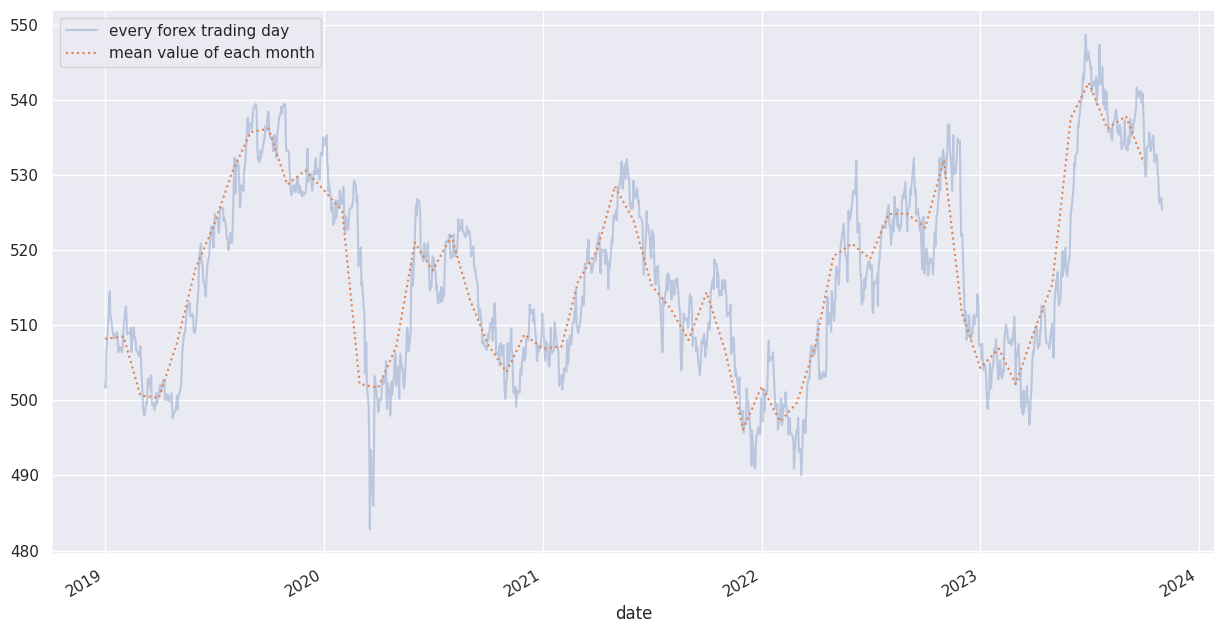

In [19]:
selling_rates.plot(alpha=0.3, style='-', label = 'every forex trading day')
selling_rates.resample('MS').mean().plot(style=':', label='mean value of each month')

plt.legend()

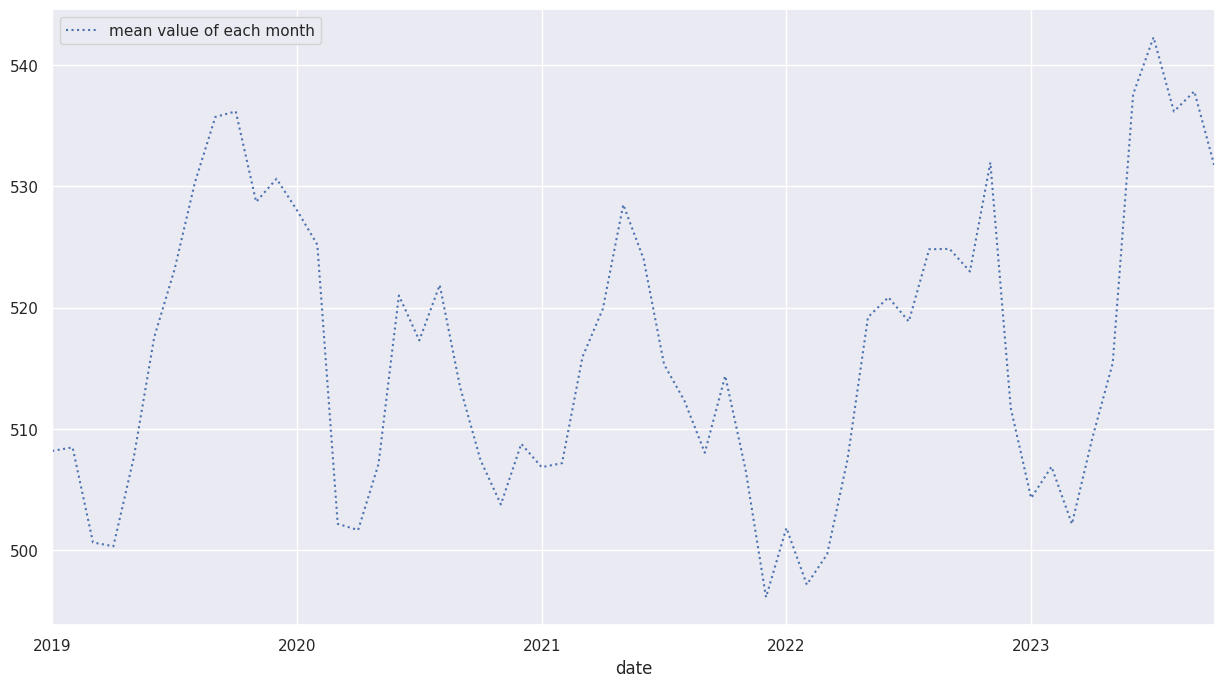

/home/yjiang23/anaconda3/envs/venv_pro/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yjiang23/anaconda3/envs/venv_pro/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yjiang23/anaconda3/envs/venv_pro/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yjiang23/anaconda3/envs/venv_pro/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction r

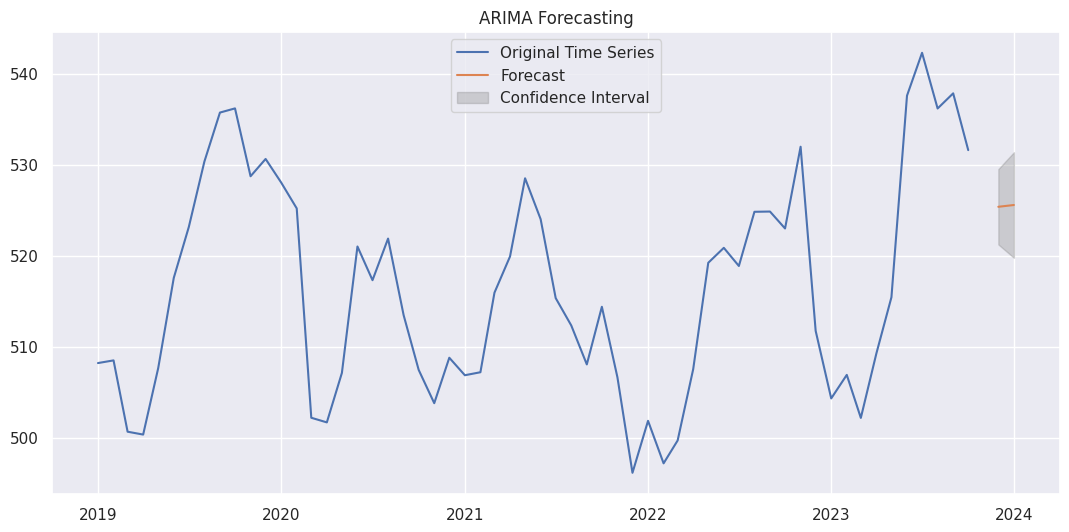

In [20]:
# Plot the monthly average of time series data
selling_rates.resample('MS').mean().plot(style=':', label='mean value of each month')
plt.legend()
plt.show()

# Define ARIMA model

p, d, q = 2, 2, 1
model = ARIMA(selling_rates, order=(p, d, q))

# Fit the model
results = model.fit()

# Forecast future values
forecast_steps = 2
forecast = results.get_forecast(steps=forecast_steps)

# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Create a new date range for the forecast period
forecast_date_rng = pd.date_range(start=selling_rates.resample('MS').mean().index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Plot the results
plt.figure(figsize=(13, 6))
plt.plot(selling_rates.resample('MS').mean(), label='Original Time Series')
plt.plot(forecast_date_rng, forecast_values, label='Forecast')
plt.fill_between(forecast_date_rng, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Forecasting')
plt.legend()
plt.show()